In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import gc

from hyperion.model import AnalyticalYSOModel, ModelOutput
from hyperion.util.constants import rsun, lsun, au, msun, yr, c, pc


plt.rcParams['font.weight'] = 'normal'
plt.rcParams['text.usetex']=False
plt.rcParams['font.family']='stixgeneral'
plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.size'] = 20
plt.rc('figure', facecolor='w')

# 3. a)

## Basically, all the random number in the code uses two kinds of random number generator (RNG) depending on the precision (single/double) of the required random number.
## Single precision RNG is from "Numerical Recipes" and double precision RNG uses an algorithm based on "The 64-bit universal RNG", Marsaglia & Tsang (2004).
## Both RNGs start from a seed and modify it with modulus algorithm that we learned from the class.
## After that, using the modified seed, RNGs generate random numbers.
## Single one uses operators like bitwise OR and comparisons to get the return value and double one uses comparisons and add operators.
## I really don't understand how those algorithms can get a uniformly distributed random numbers but these are what they are doing.
## The one thing I am sure is that this is a totally deterministic RNG.

<br>


## The code uses random number sampling to propagate a photon until it reaches a sampled optical depth $\tau$.
## Using PDF of exp($\tau$) and extracting from range of $0 \le$ $\tau=$ log$(-\zeta)$ $\le \infty$ and $0\le$ log$\zeta$ $\le 1$, the code can randomly sample $\tau$.
## However, because it cannot be done because it has an infinity, the code uses bisection and iteration to random sample.

<br>

## Also, the code uses random number when it decides direction of the photon emitted from the radiation sources and scattered when it should be scattered.
## Naturally, $\theta$ should be sampled with care, by randomly samling cos$\theta$.
## During the scattering, the position of scattering where actually the photon is emitted is also determined by random sampling of the position within the photon-scattering cell.

<br>

## Frequency of the emitted photons are also randomly sampled from the given range.


# 3. b)

In [46]:
# Initalize the model
m = AnalyticalYSOModel()

# Read in stellar spectrum
wav, fnu = np.loadtxt('kt04000g+3.5z-2.0.ascii', unpack=True)
nu = c / (wav * 1.e-4)

# Set the stellar parameters
m.star.radius = 2 * rsun # 2.09 * rsun
m.star.spectrum = (nu, fnu)
m.star.luminosity = 5 * lsun # lsun
m.star.mass = 0.5 * msun

# Add a flared disk
disk = m.add_flared_disk()
disk.mass = 0.01 * msun
disk.rmin = 10 * m.star.radius # 7 * m.star.radius
disk.rmax = 200 * au
disk.r_0 = m.star.radius
disk.h_0 = 0.01 * disk.r_0
disk.p = -1.0 # rho \propto r^{p}
disk.beta = 1.25
disk.dust = 'kmh94_3.1_full.hdf5' # 'kmh_lite.hdf5' # Kim Martin Hendry

# Add an envelope
envelope = m.add_power_law_envelope()
envelope.mass = 0.4 * msun
envelope.rmin = 200 * au # 7 * m.star.radius
envelope.rmax = 10000 * au # 5000 * au
envelope.r_0 = m.star.radius
envelope.power = -2.0 # rho \propto r^{p}
envelope.dust = 'kmh94_3.1_full.hdf5' # 'kmh_lite.hdf5' # Kim Martin Hendry

# Use raytracing to improve s/n of thermal/source emission
m.set_raytracing(True)

# Use the modified random walk
m.set_mrw(True, gamma=2.)

# Set up grid
m.set_spherical_polar_grid_auto(100,50,5) # (800, 400, 10) #(400,200,10) # (200, 100, 5) # m.set_spherical_polar_grid_auto(399, 199, 1)

# Set up SED
sed = m.add_peeled_images(sed=True, image=False)
sed.set_viewing_angles(np.linspace(0., 90., 10), np.repeat(45., 10))
sed.set_wavelength_range(300, 0.05, 2000.)


# Add multi-wavelength image for a single viewing angle
image = m.add_peeled_images(sed=False, image=True)
image.set_wavelength_range(300, 0.05, 2000.)
image.set_viewing_angles([90], [45])
image.set_image_size(800, 800)
image_limit=1e3*au #1.5e4*au
image.set_image_limits(-image_limit, image_limit, -image_limit, image_limit)


# Set number of photons
n_photon=1e7
m.set_n_photons(initial=n_photon, imaging=n_photon, raytracing_sources=n_photon, raytracing_dust=n_photon)

# Set number of temperature iterations and convergence criterion
m.set_n_initial_iterations(20)
m.set_convergence(True, percentile=99.0, absolute=2.0, relative=1.1)


# Write out file
m.write('1e7_low.rtin')
#m.run('try1.rtout', mpi=True)

INFO: Disk density is being re-scaled by a factor of 1.08 to give the correct mass. [hyperion.densities.flared_disk]
INFO: Normalization factor for envelope mass:  0.97 [hyperion.densities.power_law_envelope]
INFO: Merging densities (identical hashes) [hyperion.model.model]


Text(0, 0.5, '$\\lambda F_\\lambda$ [ergs/cm$^2/s$]')

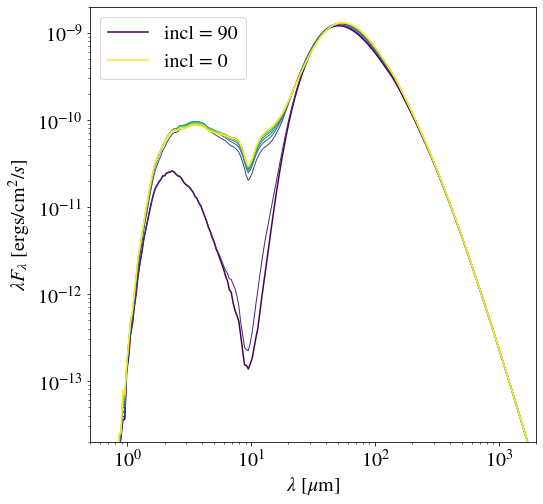

In [149]:
mo = ModelOutput('1e7.rtout')
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)

n=10
incl=np.arange(0,100,10)
colors = pl.cm.viridis(np.linspace(1,0,n))

for i in range(n):
    sed = mo.get_sed(aperture=-1, distance=300. * pc, inclination=n-1-i)
    if i==0 or i ==n-1:
        ax.loglog(sed.wav, sed.val.transpose(), color=colors[n-1-i], lw=1.5, linestyle='-', label='incl = {}'.format(incl[n-1-i]))
        continue
    ax.loglog(sed.wav, sed.val.transpose(), color=colors[n-1-i], lw=1, linestyle='-'), #label='incl = {}'.format(incl[i]))

ax.legend()

ax.set_xlim(0.5, 2000.)
ax.set_ylim(2.e-14, 2e-9)
ax.set_xlabel(r'$\lambda$ [$\mu$m]')
ax.set_ylabel(r'$\lambda F_\lambda$ [ergs/cm$^2/s$]')

## SED shows an absorption near $\lambda \sim 10 \mu$m and has two bumps.
## When $\lambda \lesssim 1 \mu$m or $\lambda \gtrsim 1000 \mu$m, there is very little energy.

## When viewing angle increases, SED shows a distinct absorption feature near $\lambda \sim 10 \mu$m.
## This is because the photons emitted from the center star is scattered by the protostellar disk.
## If the viewing angle is 90 degree, the absorption feature can be seen most clearly.
## This can be also seen in the bottommost figure that shows the shape of disk and envelope observed from 90 degree viewing angle.

# 3. c)

# Grid: (200, 100, 5)

Text(0, 0.5, '$\\lambda F_\\lambda$ [ergs/cm$^2/s$]')

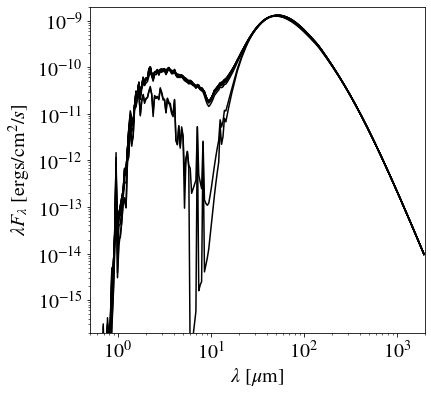

In [82]:
mo = ModelOutput('1e4.rtout')
sed = mo.get_sed(aperture=-1, distance=300. * pc)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.loglog(sed.wav, sed.val.transpose(), color='black')
ax.set_xlim(0.5, 2000.)
ax.set_ylim(2.e-16, 2e-9)
ax.set_xlabel(r'$\lambda$ [$\mu$m]')
ax.set_ylabel(r'$\lambda F_\lambda$ [ergs/cm$^2/s$]')
#fig.savefig('1e4.png', bbox_inches='tight')


Text(0, 0.5, '$\\lambda F_\\lambda$ [ergs/cm$^2/s$]')

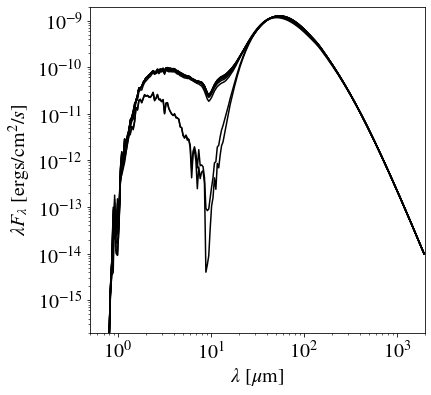

In [83]:
mo = ModelOutput('1e5.rtout')
sed = mo.get_sed(aperture=-1, distance=300. * pc)
#sed = mo.get_sed(aperture=-1, distance=140. * pc)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.loglog(sed.wav, sed.val.transpose(), color='black')
ax.set_xlim(0.5, 2000.)
ax.set_ylim(2.e-16, 2e-9)
ax.set_xlabel(r'$\lambda$ [$\mu$m]')
ax.set_ylabel(r'$\lambda F_\lambda$ [ergs/cm$^2/s$]')


Text(0, 0.5, '$\\lambda F_\\lambda$ [ergs/cm$^2/s$]')

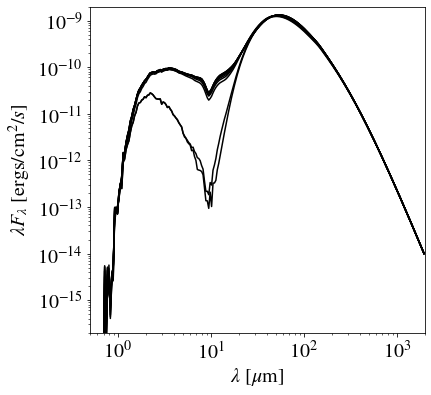

In [84]:
mo = ModelOutput('1e6.rtout')
sed = mo.get_sed(aperture=-1, distance=300. * pc)
#sed = mo.get_sed(aperture=-1, distance=140. * pc)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.loglog(sed.wav, sed.val.transpose(), color='black')
ax.set_xlim(0.5, 2000.)
ax.set_ylim(2.e-16, 2e-9)
ax.set_xlabel(r'$\lambda$ [$\mu$m]')
ax.set_ylabel(r'$\lambda F_\lambda$ [ergs/cm$^2/s$]')

Text(0, 0.5, '$\\lambda F_\\lambda$ [ergs/cm$^2/s$]')

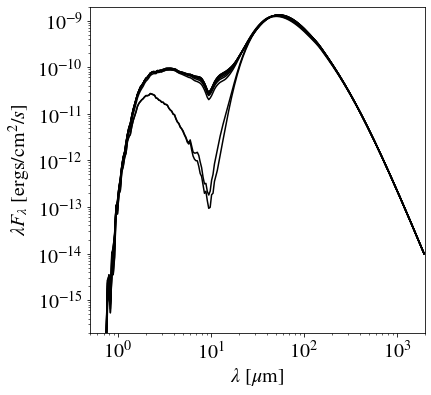

In [21]:
mo = ModelOutput('2e6_90.rtout')
sed = mo.get_sed(aperture=-1, distance=300. * pc)
#sed = mo.get_sed(aperture=-1, distance=140. * pc)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.loglog(sed.wav, sed.val.transpose(), color='black')
ax.set_xlim(0.5, 2000.)
ax.set_ylim(2.e-16, 2e-9)
ax.set_xlabel(r'$\lambda$ [$\mu$m]')
ax.set_ylabel(r'$\lambda F_\lambda$ [ergs/cm$^2/s$]')

Text(0, 0.5, '$\\lambda F_\\lambda$ [ergs/cm$^2/s$]')

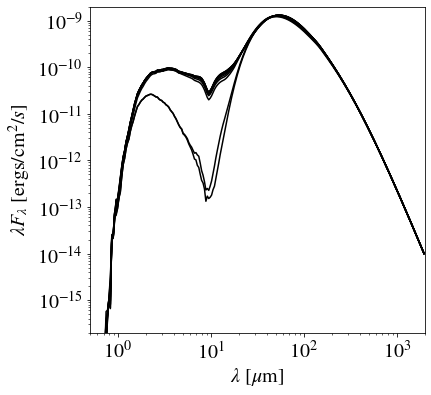

In [167]:
mo = ModelOutput('5e6.rtout')
sed = mo.get_sed(aperture=-1, distance=300. * pc)
#sed = mo.get_sed(aperture=-1, distance=140. * pc)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.loglog(sed.wav, sed.val.transpose(), color='black')
ax.set_xlim(0.5, 2000.)
ax.set_ylim(2.e-16, 2e-9)
ax.set_xlabel(r'$\lambda$ [$\mu$m]')
ax.set_ylabel(r'$\lambda F_\lambda$ [ergs/cm$^2/s$]')

Text(0, 0.5, '$\\lambda F_\\lambda$ [ergs/cm$^2/s$]')

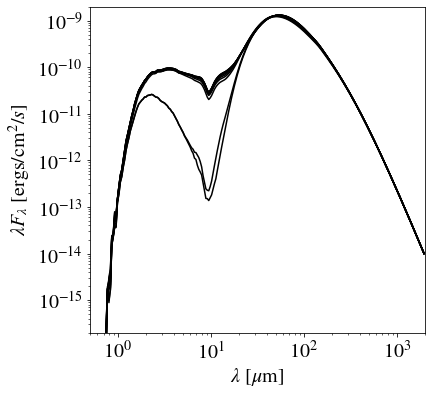

In [150]:
mo = ModelOutput('1e7.rtout')
sed = mo.get_sed(aperture=-1, distance=300. * pc)
#sed = mo.get_sed(aperture=-1, distance=140. * pc)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.loglog(sed.wav, sed.val.transpose(), color='black')
ax.set_xlim(0.5, 2000.)
ax.set_ylim(2.e-16, 2e-9)
ax.set_xlabel(r'$\lambda$ [$\mu$m]')
ax.set_ylabel(r'$\lambda F_\lambda$ [ergs/cm$^2/s$]')

## It seems $n_{\rm photon} \gtrsim 5\times10^{6}$ can generate a converged SED.
## If $n_{\rm photon}$ is too small, especially when the optical depth is high, the SED doesn't converge well.

# Grid: (100, 50, 5)

Text(0, 0.5, '$\\lambda F_\\lambda$ [ergs/cm$^2/s$]')

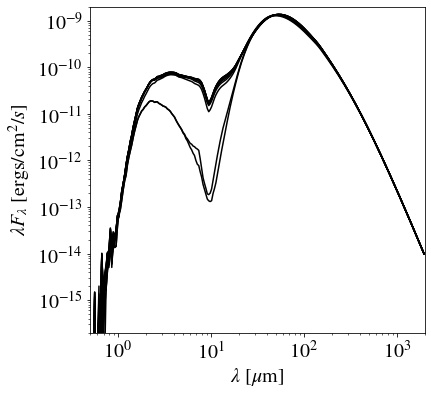

In [47]:
mo = ModelOutput('1e7_low.rtout')
sed = mo.get_sed(aperture=-1, distance=300. * pc)
#sed = mo.get_sed(aperture=-1, distance=140. * pc)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.loglog(sed.wav, sed.val.transpose(), color='black')
ax.set_xlim(0.5, 2000.)
ax.set_ylim(2.e-16, 2e-9)
ax.set_xlabel(r'$\lambda$ [$\mu$m]')
ax.set_ylabel(r'$\lambda F_\lambda$ [ergs/cm$^2/s$]')

# Grid: (400, 200, 10)

Text(0, 0.5, '$\\lambda F_\\lambda$ [ergs/cm$^2/s$]')

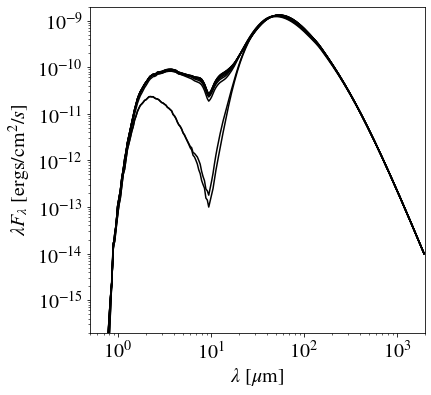

In [32]:
mo = ModelOutput('1e7_mid.rtout')
sed = mo.get_sed(aperture=-1, distance=300. * pc)
#sed = mo.get_sed(aperture=-1, distance=140. * pc)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.loglog(sed.wav, sed.val.transpose(), color='black')
ax.set_xlim(0.5, 2000.)
ax.set_ylim(2.e-16, 2e-9)
ax.set_xlabel(r'$\lambda$ [$\mu$m]')
ax.set_ylabel(r'$\lambda F_\lambda$ [ergs/cm$^2/s$]')

# Grid: (800, 400, 10)

Text(0, 0.5, '$\\lambda F_\\lambda$ [ergs/cm$^2/s$]')

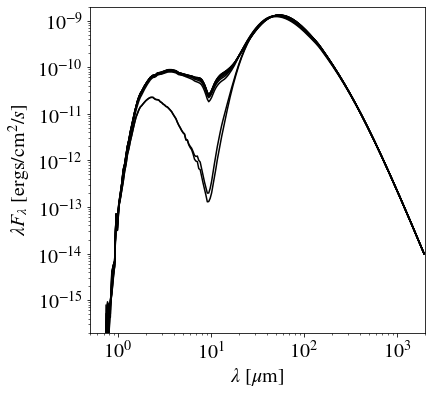

In [45]:
mo = ModelOutput('1e7_high.rtout')
sed = mo.get_sed(aperture=-1, distance=300. * pc)
#sed = mo.get_sed(aperture=-1, distance=140. * pc)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.loglog(sed.wav, sed.val.transpose(), color='black')
ax.set_xlim(0.5, 2000.)
ax.set_ylim(2.e-16, 2e-9)
ax.set_xlabel(r'$\lambda$ [$\mu$m]')
ax.set_ylabel(r'$\lambda F_\lambda$ [ergs/cm$^2/s$]')

## Grid resolution doesn't seem to change the result much if it has an enough resolution.

# 3. d)

In [12]:
gc.collect()

2360

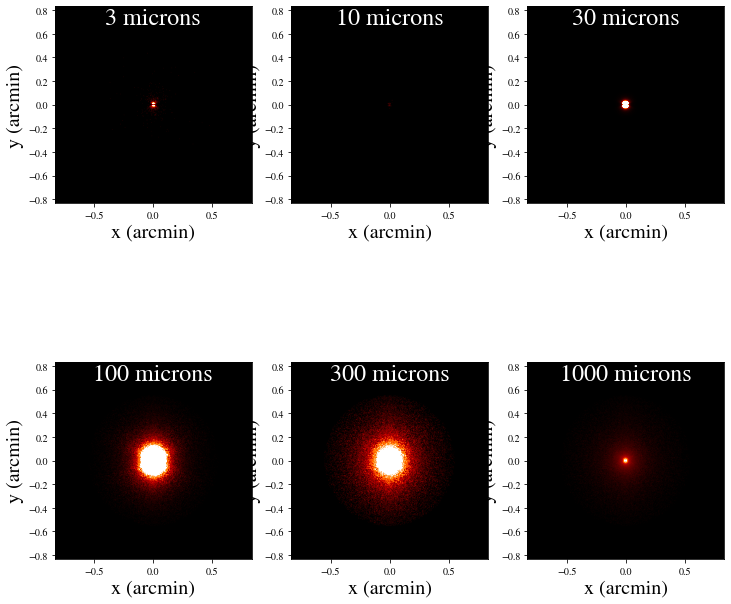

In [17]:
# Open the model
m = ModelOutput('2e6_90.rtout')

# Extract the image for the first inclination, and scale to 300pc. We
# have to specify group=1 as there is no image in group 0.
image = m.get_image(inclination=0, distance=300 * pc, units='MJy/sr', group=1)

# Open figure and create axes
fig = plt.figure(figsize=(12,12))

# Pre-set maximum for colorscales
VMAX = {}
VMAX[3] = 100.
VMAX[10] = 100.
VMAX[30] = 100.
VMAX[100] = 100.
VMAX[300] = 100.
VMAX[1000] = 100.

# We will now show four sub-plots, each one for a different wavelength
for i, wav in enumerate([3, 10, 30, 100, 300, 1000]):

    ax = fig.add_subplot(2, 3, i + 1)

    # Find the closest wavelength
    iwav = np.argmin(np.abs(wav - image.wav))

    # Calculate the image width in arcseconds given the distance used above
    w = np.degrees(image_limit / image.distance) * 60

    # This is the command to show the image. The parameters vmin and vmax are
    # the min and max levels for the colorscale (remove for default values).
    ax.imshow(np.sqrt(image.val[:, :, iwav]), vmin=0, vmax=np.sqrt(VMAX[wav]),
              cmap=plt.cm.gist_heat, origin='lower', extent=[-w, w, -w, w])

    # Finalize the plot
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlabel('x (arcmin)')
    ax.set_ylabel('y (arcmin)')
    ax.set_title(str(wav) + ' microns', y=0.88, x=0.5, color='white')

#fig.savefig('simple_cube_plot.png', bbox_inches='tight')

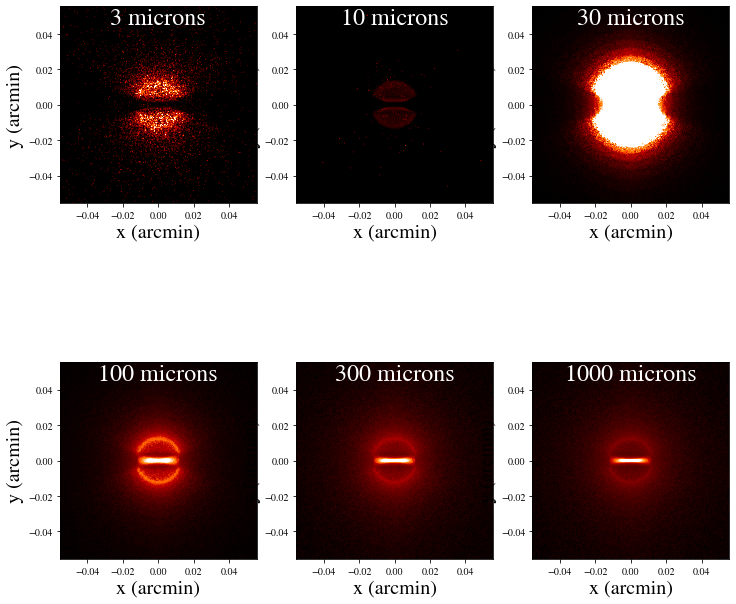

In [29]:
# Open the model
m = ModelOutput('1e7_90.rtout')

# Extract the image for the first inclination, and scale to 300pc. We
# have to specify group=1 as there is no image in group 0.
image = m.get_image(inclination=0, distance=300 * pc, units='MJy/sr', group=1)

# Open figure and create axes
fig = plt.figure(figsize=(12,12))

# Pre-set maximum for colorscales
VMAX = {}
VMAX[3] = 100.
VMAX[10] = 100.
VMAX[30] = 500.
VMAX[100] = 500000.
VMAX[300] = 50000.
VMAX[1000] = 1000.

# We will now show four sub-plots, each one for a different wavelength
for i, wav in enumerate([3, 10, 30, 100, 300, 1000]):

    ax = fig.add_subplot(2, 3, i + 1)

    # Find the closest wavelength
    iwav = np.argmin(np.abs(wav - image.wav))

    # Calculate the image width in arcseconds given the distance used above
    w = np.degrees(image_limit / image.distance) * 60

    # This is the command to show the image. The parameters vmin and vmax are
    # the min and max levels for the colorscale (remove for default values).
    ax.imshow(np.sqrt(image.val[:, :, iwav]), vmin=0, vmax=np.sqrt(VMAX[wav]),
              cmap=plt.cm.gist_heat, origin='lower', extent=[-w, w, -w, w])

    # Finalize the plot
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlabel('x (arcmin)')
    ax.set_ylabel('y (arcmin)')
    ax.set_title(str(wav) + ' microns', y=0.88, x=0.5, color='white')

#fig.savefig('simple_cube_plot.png', bbox_inches='tight')

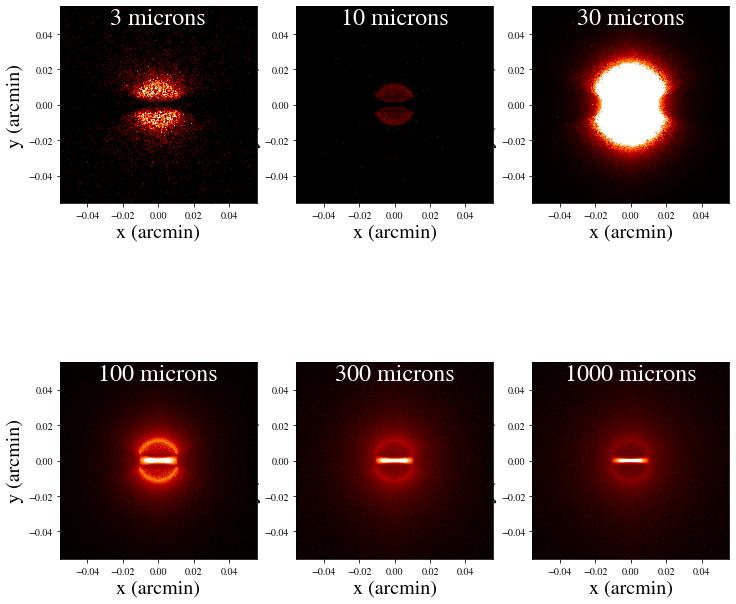

In [49]:
# Open the model
m = ModelOutput('1e7_high.rtout')

# Extract the image for the first inclination, and scale to 300pc. We
# have to specify group=1 as there is no image in group 0.
image = m.get_image(inclination=0, distance=300 * pc, units='MJy/sr', group=1)

# Open figure and create axes
fig = plt.figure(figsize=(12,12))

# Pre-set maximum for colorscales
VMAX = {}
VMAX[3] = 100.
VMAX[10] = 100.
VMAX[30] = 500.
VMAX[100] = 500000.
VMAX[300] = 50000.
VMAX[1000] = 1000.

# We will now show four sub-plots, each one for a different wavelength
for i, wav in enumerate([3, 10, 30, 100, 300, 1000]):

    ax = fig.add_subplot(2, 3, i + 1)

    # Find the closest wavelength
    iwav = np.argmin(np.abs(wav - image.wav))

    # Calculate the image width in arcseconds given the distance used above
    w = np.degrees(image_limit / image.distance) * 60

    # This is the command to show the image. The parameters vmin and vmax are
    # the min and max levels for the colorscale (remove for default values).
    ax.imshow(np.sqrt(image.val[:, :, iwav]), vmin=0, vmax=np.sqrt(VMAX[wav]),
              cmap=plt.cm.gist_heat, origin='lower', extent=[-w, w, -w, w])

    # Finalize the plot
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlabel('x (arcmin)')
    ax.set_ylabel('y (arcmin)')
    ax.set_title(str(wav) + ' microns', y=0.88, x=0.5, color='white')

#fig.savefig('simple_cube_plot.png', bbox_inches='tight')

(0.0, 1.0)

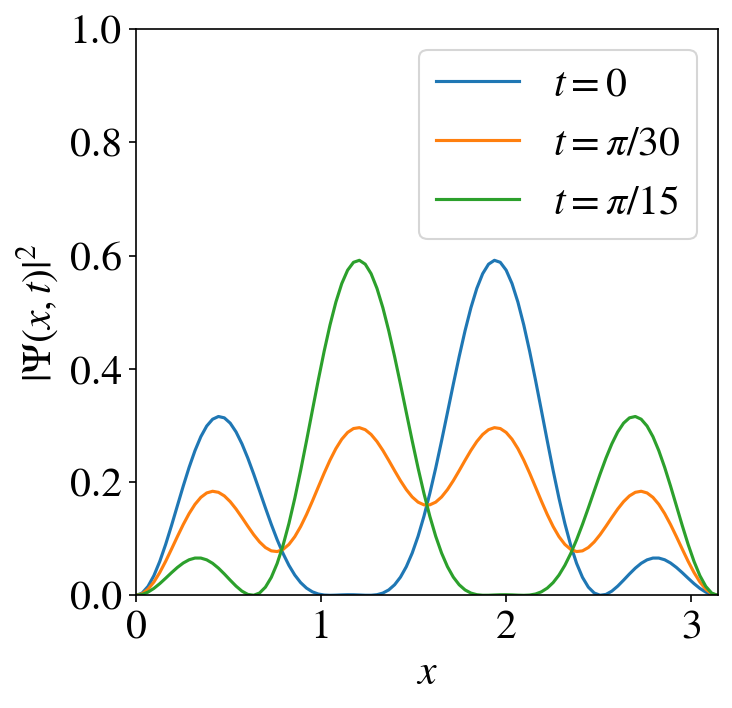

In [44]:
x=np.linspace(0,np.pi,100)
y1=(np.sin(x)+np.sin(4*x))**2/(2*np.pi)
y2=(np.sin(x)**2+np.sin(4*x)**2)/(2*np.pi)
y3=(np.sin(x)-np.sin(4*x))**2/(2*np.pi)


fig = plt.figure(figsize=(5,5),dpi=150)
ax = fig.add_subplot(111)

ax.plot(x,y1,label='$t=0$')
ax.plot(x,y2,label='$t=\pi/30$')
ax.plot(x,y3,label='$t=\pi/15$')

ax.legend()

ax.set_xlabel('$x$')
ax.set_ylabel('$|\Psi (x,t)|^{2}$')
ax.set_xlim(0, np.pi)
ax.set_ylim(0,1)